In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable

### Loading Dataset

11490434/11490434 [==============================] - 1s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


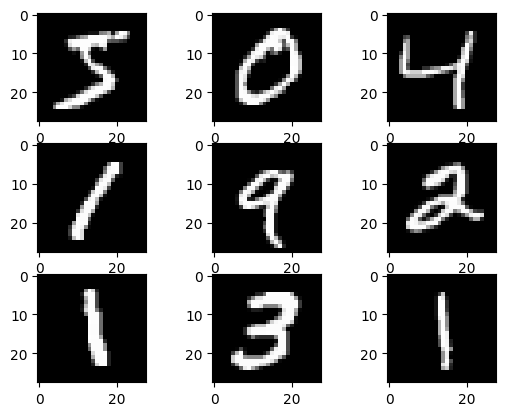

In [4]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

(X_train, y_train), (X_test, y_test) = mnist.load_data()
# print shape
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
# plot first few images
for i in range(9):
 plt.subplot(330 + 1 + i)
 plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))

plt.show()

### Preprocessing

In [5]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()
print(torch_X_train.shape)
print(torch_X_test.shape)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)


torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


### Create a CNN Model

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        #10 numbers
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x) #1 -> 32
        x = F.relu(x)

        x = self.conv2(x) #32 -> 32
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x) #32 -> 64
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


### Fitting model

In [14]:
def fit(model, optimizer, train_loader):
    # Use GPU to train
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    EPOCHS = 20
    model.train()
    loss_values = []

    for epoch in range(EPOCHS):
        correct = 0
        running_loss = 0.0
        total_samples = 0

        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)

            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(output.data, 1)
            total_samples += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        accuracy = correct / total_samples
        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)

        print('[Epoch %d] Loss: %.3f, Accuracy: %.3f' % (epoch + 1, epoch_loss, accuracy))

    return loss_values


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = CNN().to(device)
Adam = torch.optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.999))
Adam_model = fit(cnn, Adam, train_loader)

[Epoch 1] Loss: 0.404, Accuracy: 0.879
[Epoch 2] Loss: 0.187, Accuracy: 0.946
[Epoch 3] Loss: 0.166, Accuracy: 0.954
[Epoch 4] Loss: 0.153, Accuracy: 0.958
[Epoch 5] Loss: 0.153, Accuracy: 0.959
[Epoch 6] Loss: 0.150, Accuracy: 0.961
[Epoch 7] Loss: 0.150, Accuracy: 0.961
[Epoch 8] Loss: 0.142, Accuracy: 0.963
[Epoch 9] Loss: 0.150, Accuracy: 0.962
[Epoch 10] Loss: 0.146, Accuracy: 0.963
[Epoch 11] Loss: 0.150, Accuracy: 0.962
[Epoch 12] Loss: 0.146, Accuracy: 0.964
[Epoch 13] Loss: 0.144, Accuracy: 0.965
[Epoch 14] Loss: 0.138, Accuracy: 0.966
[Epoch 15] Loss: 0.148, Accuracy: 0.964
[Epoch 16] Loss: 0.143, Accuracy: 0.964
[Epoch 17] Loss: 0.140, Accuracy: 0.966
[Epoch 18] Loss: 0.151, Accuracy: 0.963
[Epoch 19] Loss: 0.139, Accuracy: 0.966
[Epoch 20] Loss: 0.147, Accuracy: 0.965


Training SGD

In [28]:
cnn_sgd = CNN().to(device)
SGD_optimizer = torch.optim.SGD(cnn_sgd.parameters(), lr=0.001)
SGD_model = fit(cnn_sgd, SGD_optimizer, train_loader)

[Epoch 1] Loss: 1.131, Accuracy: 0.620
[Epoch 2] Loss: 0.438, Accuracy: 0.864
[Epoch 3] Loss: 0.298, Accuracy: 0.909
[Epoch 4] Loss: 0.245, Accuracy: 0.926
[Epoch 5] Loss: 0.210, Accuracy: 0.938
[Epoch 6] Loss: 0.185, Accuracy: 0.944
[Epoch 7] Loss: 0.171, Accuracy: 0.948
[Epoch 8] Loss: 0.155, Accuracy: 0.954
[Epoch 9] Loss: 0.147, Accuracy: 0.956
[Epoch 10] Loss: 0.135, Accuracy: 0.959
[Epoch 11] Loss: 0.132, Accuracy: 0.961
[Epoch 12] Loss: 0.127, Accuracy: 0.961
[Epoch 13] Loss: 0.117, Accuracy: 0.965
[Epoch 14] Loss: 0.115, Accuracy: 0.965
[Epoch 15] Loss: 0.111, Accuracy: 0.967
[Epoch 16] Loss: 0.106, Accuracy: 0.967
[Epoch 17] Loss: 0.102, Accuracy: 0.969
[Epoch 18] Loss: 0.098, Accuracy: 0.971
[Epoch 19] Loss: 0.097, Accuracy: 0.970
[Epoch 20] Loss: 0.090, Accuracy: 0.973


Plot Training Loss

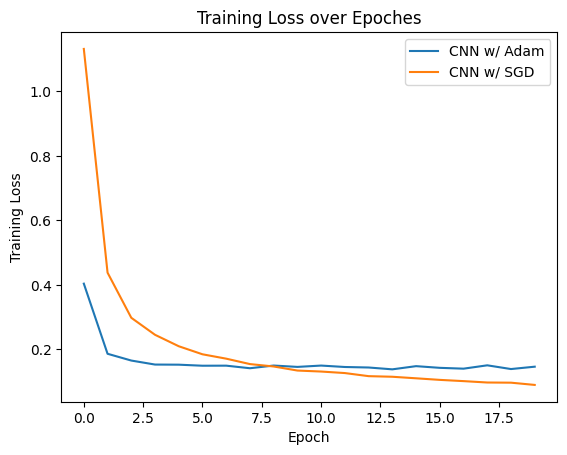

In [29]:
plt.plot(Adam_model, label='CNN w/ Adam')
plt.plot(SGD_model,label='CNN w/ SGD')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epoches')
plt.legend()
plt.show()

In [24]:
def evaluate(model):
    correct = 0
    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct) / (len(test_loader)*BATCH_SIZE)))

In [31]:
evaluate(cnn)

Test accuracy:0.986% 


In [30]:
evaluate(cnn_sgd)

Test accuracy:0.970% 


Exploring Adam Learning Rate

[Epoch 1] Loss: 0.958, Accuracy: 0.712
[Epoch 2] Loss: 0.221, Accuracy: 0.933
[Epoch 3] Loss: 0.142, Accuracy: 0.956
[Epoch 4] Loss: 0.113, Accuracy: 0.965
[Epoch 5] Loss: 0.094, Accuracy: 0.971
[Epoch 6] Loss: 0.083, Accuracy: 0.975
[Epoch 7] Loss: 0.076, Accuracy: 0.977
[Epoch 8] Loss: 0.071, Accuracy: 0.979
[Epoch 9] Loss: 0.061, Accuracy: 0.982
[Epoch 10] Loss: 0.057, Accuracy: 0.983
[Epoch 11] Loss: 0.054, Accuracy: 0.983
[Epoch 12] Loss: 0.054, Accuracy: 0.983
[Epoch 13] Loss: 0.050, Accuracy: 0.985
[Epoch 14] Loss: 0.048, Accuracy: 0.986
[Epoch 15] Loss: 0.045, Accuracy: 0.986
[Epoch 16] Loss: 0.043, Accuracy: 0.987
[Epoch 17] Loss: 0.042, Accuracy: 0.987
[Epoch 18] Loss: 0.040, Accuracy: 0.987
[Epoch 19] Loss: 0.039, Accuracy: 0.988
[Epoch 20] Loss: 0.038, Accuracy: 0.988
[Epoch 1] Loss: 0.039, Accuracy: 0.988
[Epoch 2] Loss: 0.038, Accuracy: 0.988
[Epoch 3] Loss: 0.036, Accuracy: 0.989
[Epoch 4] Loss: 0.033, Accuracy: 0.990
[Epoch 5] Loss: 0.033, Accuracy: 0.990
[Epoch 6] Loss

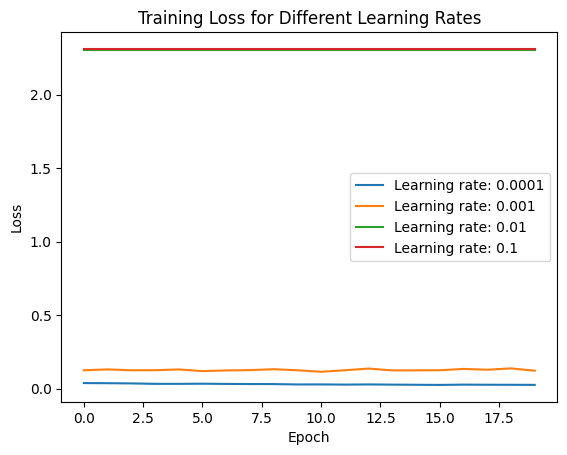

In [32]:
all_loss_values = []
learning_rates = [0.0001, 0.001, 0.01, 0.1]

for lr in learning_rates:
  cnn = CNN().to(device)
  Adam = torch.optim.Adam(cnn.parameters(), lr=lr, betas=(0.9, 0.999))
  Adam_model = fit(cnn, Adam, train_loader)

  loss_values = fit(cnn,Adam, train_loader)
  all_loss_values.append(loss_values)

  plt.plot(loss_values, label=f'Learning rate: {lr}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Different Learning Rates')
plt.legend()
plt.show()